In [1]:
%pip install simpy numpy pandas matplotlib scipy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import itertools
import logging

import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Configure logging: force root logger to have a stream handler so output is visible
logging.basicConfig(level=logging.WARN, format="%(message)s", force=True)
logger = logging.getLogger(__name__)

RANDOM_SEED = 42
NUM_COUNTERS = 1  # Number of ID counters at the checkpoint
SIM_TIME = 20  # Simulation time in minutes
NUM_SCANNERS = 1
SCANNER_LOW = 0.5
SCANNER_HIGH = 1.0
BETA1 = 0.2
BETA2 = 0.75

# # Function to run the simulation and return a DataFrame
def run_simulation(
    num_counters=NUM_COUNTERS,
    num_scanners=NUM_SCANNERS,
    sim_time=SIM_TIME,
    random_seed=RANDOM_SEED,
    log_level="WARN",
    beta1=BETA1,
):
    rng = np.random.default_rng(random_seed)
    data = []
    logger.setLevel(log_level)

    def NoInSystem(R: simpy.Resource):
        """Total number of customers in the resource R"""
        # Support resources that may not have put_queue/users attributes
        return max(0, len(getattr(R, "put_queue", [])) + len(getattr(R, "users", [])))


    class Scanners:
        """Passenger scanners helper.

        Maintains a list of scanner resources and exposes a Customer process
        that a arriving passenger can use: choose shortest queue, wait, then
        take a uniform scanning time between wait_low and wait_high.
        """

        def __init__(self, env, num_scanners, wait_low, wait_high):
            self.env = env
            self.num_scanners = num_scanners
            self.wait_low = wait_low
            self.wait_high = wait_high
            self.scanners = [simpy.Resource(env) for _ in range(self.num_scanners)]

        def queue_lengths(self):
            return list(map(NoInSystem, self.scanners))

        def queue(self, name, generation_time):
            """Process for a passenger to join a scanner queue and be scanned.

            Uses the scanner list and the class's environment so multiple Customer
            processes (one per passenger) run in parallel and form queues per scanner.
            """
            arrive = self.env.now
            Qlength = self.queue_lengths()

            logger.debug(
                f"t={self.env.now:7.4f} | {name} | Arrives at scanner | Queue lengths: {Qlength}"
            )
            # choose first scanner with minimal queue length
            choice = min(range(len(Qlength)), key=lambda i: Qlength[i])
            with self.scanners[choice].request() as req:
                yield req
                wait = self.env.now - arrive
                logger.debug(
                    f"t={self.env.now:7.4f} | {name} | Begins scanning at scanner {choice} | Wait time: {wait:6.4f}"
                )
                time_in_line = rng.uniform(self.wait_low, self.wait_high)
                yield self.env.timeout(time_in_line)
                total_time = self.env.now - generation_time
                logger.debug(
                    f"t={self.env.now:7.4f} | {name} | Completes scanning at scanner {choice} | Scan duration: {time_in_line:6.4f}"
                )
                logger.info(
                    f"t={self.env.now:7.4f} | {name} | Exits system | Total time in process: {total_time:6.4f}"
                )
                data.append({
                    "name": name,
                    "generation_time": generation_time,
                    "total_time": total_time
                })


    class Checkpoint:
        """A security checkpoint has a limited number of ID counters
        to check passengers in parallel.

        Passengers have to request one of the counters. When they get one,
        they can start the ID checking process and wait for it to finish (which
        takes ``check_time`` minutes).
        """

        def __init__(self, env, num_counters, beta2):
            self.env = env
            self.counter = simpy.Resource(env, num_counters)
            self.beta2 = beta2

        def check_id(self, passenger):
            """The ID checking process. It takes a ``passenger`` process
            and simulates checking their ID."""
            rate = rng.exponential(self.beta2)
            logger.debug(
                f"t={self.env.now:7.4f} | {passenger} | ID check duration: {rate:6.4f}"
            )
            yield self.env.timeout(rate)


    def passenger(env, name, cp, scanners, generation_time):
        """The passenger process (each passenger has a ``name``) arrives
        at the checkpoint (``cp``) and requests an ID counter. After ID check
        they may go to scanners if provided.
        """
        arrive_time = env.now
        logger.debug(
            f"t={env.now:7.4f} | {name} | Arrives at checkpoint | Queue length: {NoInSystem(cp.counter)}"
        )

        with cp.counter.request() as request:
            yield request
            wait_time = env.now - arrive_time
            logger.debug(
                f"t={env.now:7.4f} | {name} | Begins ID check | Wait time: {wait_time:6.4f}"
            )
            yield env.process(cp.check_id(name))
            logger.debug(f"t={env.now:7.4f} | {name} | Completes ID check")

        env.process(scanners.queue(name, generation_time))


    def setup(env, num_counters, beta1, beta2, num_scanners, scan_low, scan_high):
        """Create a passenger arrival process at the checkpoint."""
        # Create the checkpoint
        checkpoint = Checkpoint(env, num_counters, beta2)
        scanners = Scanners(env, num_scanners, scan_low, scan_high)

        passenger_count = itertools.count()

        # Create 4 initial passengers
        for _ in range(4):
            passenger_id = next(passenger_count)
            logger.debug(
                f"t={env.now:7.4f} | Passenger {passenger_id} | Generated at start"
            )
            env.process(
                passenger(env, f"Passenger {passenger_id}", checkpoint, scanners, env.now)
            )

        # Create more passengers while the simulation is running
        while True:
            arrival_delay = rng.exponential(beta1)
            yield env.timeout(arrival_delay)
            passenger_id = next(passenger_count)
            logger.debug(
                f"t={env.now:7.4f} | Passenger {passenger_id} | Generated after {arrival_delay:6.4f} delay"
            )
            env.process(
                passenger(env, f"Passenger {passenger_id}", checkpoint, scanners, env.now)
            )

    env = simpy.Environment()
    env.process(
        setup(
            env,
            num_counters=num_counters,
            beta1=beta1,
            beta2=BETA2,
            num_scanners=num_scanners,
            scan_low=SCANNER_LOW,
            scan_high=SCANNER_HIGH,
        )
    )

    env.run(until=sim_time)

    return pd.DataFrame(data)

<Axes: xlabel='generation_time'>

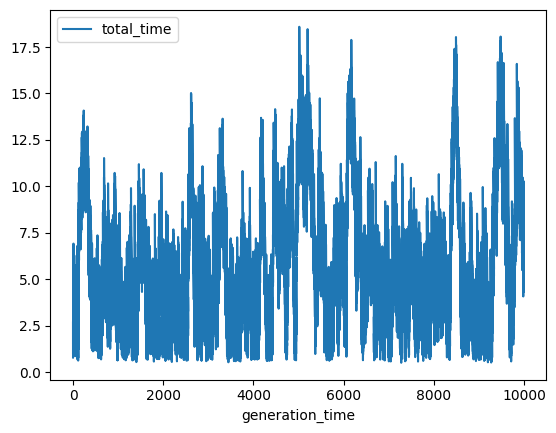

In [36]:
x = run_simulation(
    num_counters=4,
    num_scanners=4,
    sim_time=10000,
)

x.plot(
    x="generation_time",
    y="total_time"
)

One counter and one scanner show no sign of reaching stationary

<Axes: xlabel='generation_time'>

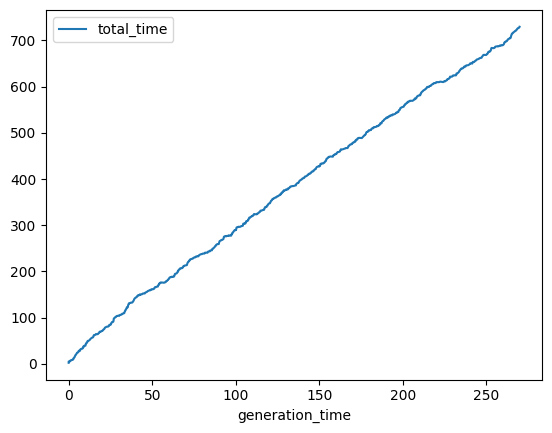

In [ ]:
x = run_simulation(
    num_counters=1,
    num_scanners=1,
    sim_time=1000,
)

x.plot(
    x="generation_time",
    y="total_time"
)

Whereas 5 counters and 5 scanners are stationary immediately

<Axes: xlabel='generation_time'>

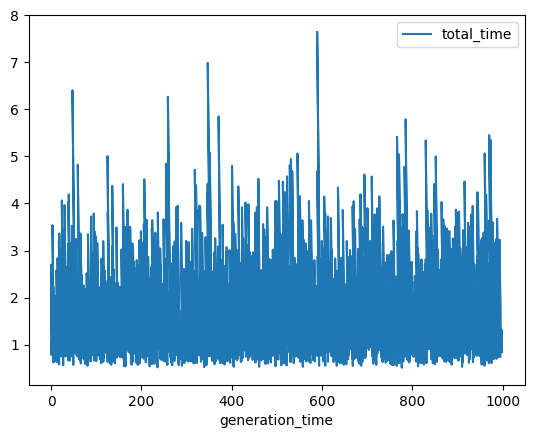

In [37]:
x = run_simulation(
    num_counters=10,
    num_scanners=10,
    sim_time=1000,
)

x.plot(
    x="generation_time",
    y="total_time"
)

In [63]:
from scipy import stats

counters_test = range(1,10)
scanners_test = range(1,10)
seeds_test = [12345, 8675309] + list(range(100))

stationary_test = []

for num_counters, num_scanners, random_seed in itertools.product(counters_test, scanners_test, seeds_test):
    print(
        f"Starting: {num_counters = }, {num_scanners = }, {random_seed = }"
    )
    run = run_simulation(
        num_counters=num_counters,
        num_scanners=num_scanners,
        random_seed=random_seed,
        sim_time=2500,
    ).assign(
        num_counters=num_counters,
        num_scanners=num_scanners,
        random_seed=random_seed,
    ).sort_values("generation_time")

    num_passengers = len(run)
    half = num_passengers // 2
    quarter = half // 2

    df_half = run.iloc[half:,:]
    df_third_quarter = run.iloc[:quarter,:]
    df_fourth_quarter = run.iloc[quarter:,:]

    third_quarter_slope, _, _, _, _ = stats.linregress(df_third_quarter["generation_time"], df_third_quarter["total_time"])
    fourth_quarter_slope, _, _, _, _ = stats.linregress(df_fourth_quarter["generation_time"], df_fourth_quarter["total_time"])

    third_quarter_mean = df_third_quarter["total_time"].mean()
    fourth_quarter_mean = df_fourth_quarter["total_time"].mean()

    stationary_test.append(
        {
            "num_counters": num_counters,
            "num_scanners": num_scanners,
            "random_seed": random_seed,
            "num_completed_passengers": num_passengers,
            "third_quarter_slope": third_quarter_slope,
            "third_quarter_mean": third_quarter_mean,
            "fourth_quarter_slope": fourth_quarter_slope,
            "fourth_quarter_mean": fourth_quarter_mean,
        }
    )

stationary_test = pd.DataFrame(stationary_test)

stable_region = (
    pd.melt(
        stationary_test,
        id_vars=["num_counters", "num_scanners", "random_seed"],
        value_vars=["third_quarter_slope","fourth_quarter_slope"],
        var_name="quarter",
        value_name="slope"
    )
    .set_index([
        "num_counters",
        "num_scanners",
        "random_seed"
    ])["slope"].abs() < 1E-3
).groupby([
    "num_counters", "num_scanners"
]).mean().reset_index()

stable_region.pivot_table(
    index="num_counters",
    columns="num_scanners",
    values="slope",
    aggfunc="sum"
)

Starting: num_counters = 1, num_scanners = 1, random_seed = 12345
Starting: num_counters = 1, num_scanners = 1, random_seed = 8675309
Starting: num_counters = 1, num_scanners = 1, random_seed = 0
Starting: num_counters = 1, num_scanners = 1, random_seed = 1
Starting: num_counters = 1, num_scanners = 1, random_seed = 2
Starting: num_counters = 1, num_scanners = 1, random_seed = 3
Starting: num_counters = 1, num_scanners = 1, random_seed = 4
Starting: num_counters = 1, num_scanners = 1, random_seed = 5
Starting: num_counters = 1, num_scanners = 1, random_seed = 6
Starting: num_counters = 1, num_scanners = 1, random_seed = 7
Starting: num_counters = 1, num_scanners = 1, random_seed = 8
Starting: num_counters = 1, num_scanners = 1, random_seed = 9
Starting: num_counters = 1, num_scanners = 1, random_seed = 10
Starting: num_counters = 1, num_scanners = 1, random_seed = 11
Starting: num_counters = 1, num_scanners = 1, random_seed = 12
Starting: num_counters = 1, num_scanners = 1, random_seed

num_scanners,1,2,3,4,5,6,7,8,9
num_counters,,,,,,,,,
1,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.343137,0.455882,0.397059,0.446078,0.504902,0.431373
5,0.0,0.0,0.0,0.627451,0.955882,0.995098,0.985294,0.995098,0.990196
6,0.0,0.0,0.0,0.696078,0.995098,1.000000,1.000000,1.000000,1.000000
7,0.0,0.0,0.0,0.681373,1.000000,1.000000,1.000000,1.000000,1.000000
8,0.0,0.0,0.0,0.676471,1.000000,1.000000,1.000000,1.000000,1.000000
9,0.0,0.0,0.0,0.651961,1.000000,1.000000,1.000000,1.000000,1.000000


In [64]:
stationary_test.to_csv("stationary_test.csv")

In [72]:
(
    stationary_test
    .query(
        "abs(fourth_quarter_slope) < 1E-3"
    )
    .pivot_table(
        index="num_counters",
        columns="num_scanners",
        values="fourth_quarter_mean",
        aggfunc="mean"
    )
).round(2)

num_scanners,4,5,6,7,8,9
num_counters,,,,,,
4,5.02,3.93,3.75,3.64,3.72,3.76
5,3.13,1.99,1.86,1.81,1.78,1.79
6,2.98,1.79,1.65,1.60,1.59,1.58
7,2.96,1.74,1.60,1.55,1.53,1.53
8,2.96,1.72,1.58,1.54,1.52,1.51
9,2.89,1.71,1.58,1.53,1.51,1.50


In [66]:
stable_region[
    stable_region.slope.abs() < 1E-3
]

,num_counters,num_scanners,slope
0,1,1,0.0
1,1,2,0.0
2,1,3,0.0
3,1,4,0.0
4,1,5,0.0
5,1,6,0.0
6,1,7,0.0
7,1,8,0.0
8,1,9,0.0
9,2,1,0.0


In [39]:
stable_region[stable_region.slope].drop(columns=["slope"]).merge(
    stationary_test,
    on=["num_counters", "num_scanners"]
).groupby(["num_counters", "num_scanners"])["fourth_quarter_mean"].agg([
    "mean", "median", "std"
])

mean    median       std
num_counters num_scanners                              
5            6             1.846086  1.854910  0.029002
             8             1.789950  1.786910  0.035123
6            5             1.793607  1.795761  0.015463
             6             1.644268  1.642721  0.016899
             7             1.608594  1.611546  0.016821
             8             1.590058  1.589396  0.013467
             9             1.585553  1.590270  0.017176
7            5             1.739057  1.736166  0.016157
             6             1.596980  1.600549  0.009998
             7             1.553750  1.550914  0.016935
             8             1.534556  1.532744  0.009402
             9             1.528636  1.525774  0.007329
8            5             1.712584  1.713880  0.017547
             6             1.583364  1.582299  0.007004
             7             1.533169  1.531497  0.008547
             8             1.516889  1.515635  0.008088
             9             1.511440  1.513439  0.006584
9            5             1.706002  1.705488  0.010745
             6             1.579602  1.577433  0.009708
             7             1.530682  1.533378  0.010274
             8             1.515254  1.514169  0.006468
             9             1.501102  1.500648  0.009020

In [44]:
counters_test = [6]
scanners_test = [5]
seeds_test = [12345, 8675309] + list(range(100))

more_seeds_test = []

for num_counters, num_scanners, random_seed in itertools.product(counters_test, scanners_test, seeds_test):
    print(
        f"Starting: {num_counters = }, {num_scanners = }, {random_seed = }"
    )
    run = run_simulation(
        num_counters=num_counters,
        num_scanners=num_scanners,
        random_seed=random_seed,
        sim_time=2500,
    ).assign(
        num_counters=num_counters,
        num_scanners=num_scanners,
        random_seed=random_seed,
    )

    more_seeds_test.append(run)

more_seeds_test = pd.concat(more_seeds_test)

Starting: num_counters = 6, num_scanners = 5, random_seed = 12345
Starting: num_counters = 6, num_scanners = 5, random_seed = 8675309
Starting: num_counters = 6, num_scanners = 5, random_seed = 0
Starting: num_counters = 6, num_scanners = 5, random_seed = 1
Starting: num_counters = 6, num_scanners = 5, random_seed = 2
Starting: num_counters = 6, num_scanners = 5, random_seed = 3
Starting: num_counters = 6, num_scanners = 5, random_seed = 4
Starting: num_counters = 6, num_scanners = 5, random_seed = 5
Starting: num_counters = 6, num_scanners = 5, random_seed = 6
Starting: num_counters = 6, num_scanners = 5, random_seed = 7
Starting: num_counters = 6, num_scanners = 5, random_seed = 8
Starting: num_counters = 6, num_scanners = 5, random_seed = 9
Starting: num_counters = 6, num_scanners = 5, random_seed = 10
Starting: num_counters = 6, num_scanners = 5, random_seed = 11
Starting: num_counters = 6, num_scanners = 5, random_seed = 12
Starting: num_counters = 6, num_scanners = 5, random_seed

In [45]:
more_seeds_stationary_test = []

for (num_counters, num_scanners, random_seed), df in merged.sort_values("generation_time").groupby(["num_counters", "num_scanners", "random_seed"]):
    num_passengers = len(df)
    half = num_passengers // 2
    quarter = half // 2

    df_half = df.iloc[half:,:]
    df_third_quarter = df.iloc[:quarter,:]
    df_fourth_quarter = df.iloc[quarter:,:]

    third_quarter_slope, _, _, _, _ = stats.linregress(df_third_quarter["generation_time"], df_third_quarter["total_time"])
    fourth_quarter_slope, _, _, _, _ = stats.linregress(df_fourth_quarter["generation_time"], df_fourth_quarter["total_time"])

    third_quarter_mean = df_third_quarter["total_time"].mean()
    fourth_quarter_mean = df_fourth_quarter["total_time"].mean()

    more_seeds_stationary_test.append(
        {
            "num_counters": num_counters,
            "num_scanners": num_scanners,
            "random_seed": random_seed,
            "num_completed_passengers": num_passengers,
            "third_quarter_slope": third_quarter_slope,
            "third_quarter_mean": third_quarter_mean,
            "fourth_quarter_slope": fourth_quarter_slope,
            "fourth_quarter_mean": fourth_quarter_mean,
        }
    )

more_seeds_stationary_test = pd.DataFrame(more_seeds_stationary_test)

<Axes: ylabel='Frequency'>

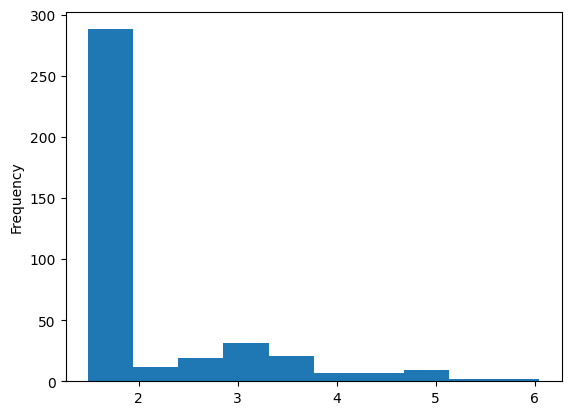

In [50]:
more_seeds_stationary_test[more_seeds_stationary_test.fourth_quarter_slope.abs() < 1E-3].fourth_quarter_mean.plot.hist()

<Axes: ylabel='Frequency'>

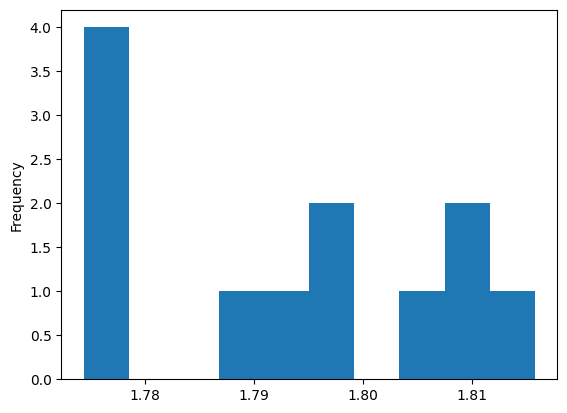

In [43]:
stable_region[stable_region.slope].drop(columns=["slope"]).merge(
    stationary_test,
    on=["num_counters", "num_scanners"]
).set_index([
    "num_counters", "num_scanners"
]).loc[(6,5)].fourth_quarter_mean.plot.hist()

In [15]:
with pd.option_context('display.max_rows', 1000):
    display(
        stable_region[stable_region.slope].drop(columns=["slope"]).merge(
            stationary_test,
            on=["num_counters", "num_scanners"]
        )
    )

,num_counters,num_scanners,random_seed,num_completed_passengers,third_quarter_slope,third_quarter_mean,fourth_quarter_slope,fourth_quarter_mean
0,5,6,0,12731,-6.769666e-05,1.976303,-9.720446e-06,1.863381
1,5,6,1,12432,2.106577e-04,1.812071,-1.675325e-07,1.837887
2,5,6,2,12464,3.813027e-04,1.757504,6.815000e-05,1.859923
3,5,6,3,12411,7.822298e-06,1.815447,-2.913177e-05,1.803125
4,5,6,4,12446,2.739266e-04,1.789243,1.093125e-04,1.882349
5,5,6,5,12539,3.242596e-05,1.721555,-9.494326e-05,1.852258
6,5,6,6,12474,4.077402e-04,1.778441,1.006170e-04,1.830185
7,5,6,7,12433,-1.162805e-04,1.804319,4.581160e-06,1.845399
8,5,6,8,12526,-3.494675e-04,1.788603,-8.823938e-05,1.858911
9,5,6,42,12439,6.550937e-06,1.895351,-1.679393e-04,1.857562


In [9]:
from scipy import stats

counters_test = range(38,42)
scanners_test = range(38,42)
seeds_test = [12345, 8675309] + list(range(100))

stationary_test = []
banned_sims = []

for num_counters, num_scanners, random_seed in itertools.product(counters_test, scanners_test, seeds_test):
    if (num_counters, num_scanners) in banned_sims:
        print(
            f"Skipping: {num_counters = }, {num_scanners = }, {random_seed = }"
        )
        continue
    else:
        print(
            f"Starting: {num_counters = }, {num_scanners = }, {random_seed = }"
        )
    
    run = run_simulation(
        num_counters=num_counters,
        num_scanners=num_scanners,
        random_seed=random_seed,
        sim_time=2500,
        beta1=1/50
    ).assign(
        num_counters=num_counters,
        num_scanners=num_scanners,
        random_seed=random_seed,
    ).sort_values("generation_time")

    num_passengers = len(run)
    half = num_passengers // 2
    quarter = half // 2

    df_half = run.iloc[half:,:]
    df_third_quarter = run.iloc[:quarter,:]
    df_fourth_quarter = run.iloc[quarter:,:]

    third_quarter_slope, _, _, _, _ = stats.linregress(df_third_quarter["generation_time"], df_third_quarter["total_time"])
    fourth_quarter_slope, _, _, _, _ = stats.linregress(df_fourth_quarter["generation_time"], df_fourth_quarter["total_time"])

    if abs(fourth_quarter_slope) > 1E-3:
        print(f"Banning all: {num_counters = }, {num_scanners = }")
        banned_sims.append((num_counters, num_scanners))
        continue

    third_quarter_mean = df_third_quarter["total_time"].mean()
    fourth_quarter_mean = df_fourth_quarter["total_time"].mean()

    stationary_test.append(
        {
            "num_counters": num_counters,
            "num_scanners": num_scanners,
            "random_seed": random_seed,
            "num_completed_passengers": num_passengers,
            "third_quarter_slope": third_quarter_slope,
            "third_quarter_mean": third_quarter_mean,
            "fourth_quarter_slope": fourth_quarter_slope,
            "fourth_quarter_mean": fourth_quarter_mean,
        }
    )

stationary_test = pd.DataFrame(stationary_test)

outer_join = stationary_test.merge(
    pd.DataFrame(
        banned_sims,
        columns=["num_counters", "num_scanners"]
    ),
    on=["num_counters", "num_scanners"],
    how = 'outer',
    indicator = True
)

stationary_test = outer_join[outer_join._merge == 'left_only'].drop('_merge', axis = 1)

Starting: num_counters = 38, num_scanners = 38, random_seed = 12345
Starting: num_counters = 38, num_scanners = 38, random_seed = 8675309
Starting: num_counters = 38, num_scanners = 38, random_seed = 0
Starting: num_counters = 38, num_scanners = 38, random_seed = 1
Starting: num_counters = 38, num_scanners = 38, random_seed = 2
Starting: num_counters = 38, num_scanners = 38, random_seed = 3
Starting: num_counters = 38, num_scanners = 38, random_seed = 4
Starting: num_counters = 38, num_scanners = 38, random_seed = 5
Banning all: num_counters = 38, num_scanners = 38
Skipping: num_counters = 38, num_scanners = 38, random_seed = 6
Skipping: num_counters = 38, num_scanners = 38, random_seed = 7
Skipping: num_counters = 38, num_scanners = 38, random_seed = 8
Skipping: num_counters = 38, num_scanners = 38, random_seed = 9
Skipping: num_counters = 38, num_scanners = 38, random_seed = 10
Skipping: num_counters = 38, num_scanners = 38, random_seed = 11
Skipping: num_counters = 38, num_scanners 

In [13]:
stationary_test.groupby([
    "num_counters", "num_scanners"
])["fourth_quarter_mean"].mean().round(2).reset_index()

,num_counters,num_scanners,fourth_quarter_mean
0,39,39,2.20
1,39,40,2.06
2,39,41,2.00
3,40,39,2.02
4,40,40,1.87
5,40,41,1.80
6,41,39,1.93
7,41,40,1.79
8,41,41,1.72


In [8]:
banned_sims.assign(
    x=1
).pivot_table(
    index="num_counters",
    columns="num_scanners",
    values="x"
)

num_scanners,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44
num_counters,,,,,,,,,,,,,,,
30,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
31,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
32,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
33,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
34,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
35,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
36,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
37,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
38,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [ ]:
stable_region = (
    pd.melt(
        stationary_test,
        id_vars=["num_counters", "num_scanners", "random_seed"],
        value_vars=["third_quarter_slope","fourth_quarter_slope"],
        var_name="quarter",
        value_name="slope"
    )
    .set_index([
        "num_counters",
        "num_scanners",
        "random_seed"
    ])["slope"].abs() < 1E-3
).groupby([
    "num_counters", "num_scanners"
]).mean().reset_index()

stable_region.pivot_table(
    index="num_counters",
    columns="num_scanners",
    values="slope",
    aggfunc="sum"
)

In [ ]:
with pd.option_context('display.max_rows', 100):
    display(
        stationary_test.groupby([
            "num_counters", "num_scanners"
        ])["fourth_quarter_slope"].mean()
    )